In [20]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline

from __future__ import division
import rdflib
from rdflib.graph import Graph, ConjunctiveGraph
from rdflib import Graph, URIRef, BNode, Literal
from rdflib import RDF
from rdflib import Namespace
from rdflib.namespace import OWL, RDF, RDFS, FOAF, XSD
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
from descartes import PolygonPatch
from shapely.geometry.polygon import LinearRing
import seaborn as sns
import pandas as pd
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Populating the interactive namespace from numpy and matplotlib


In [21]:
def plotPopulation(dataSwiss, string, string2, f1, f2):
    df = pd.DataFrame()
    df['name'] = dataSwiss[string]
    df['pop'] = dataSwiss[string2]
    df['pop'] = df['pop'].astype(int)
    df = df.drop_duplicates('name', keep='last')
    df = df[df['pop']>0].reset_index(drop=True)
    df = df.sort_values('pop')
    
    colors = 'Greens'
    bg_color = 'black'
    fg_color = 'white'

    fig = plt.figure(facecolor=bg_color, edgecolor=fg_color, figsize=(20,7.5))
    axes = plt.axes((0.1, 0.1, 0.8, 0.8), axisbg=bg_color)
    axes.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    axes.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    for spine in axes.spines.values():
        spine.set_color(fg_color)
    axes.grid(False)
    x = np.linspace(0, 2 * np.pi, 100)
    y = np.sin(x)

    sns.set(font_scale = 2)
    gplot = sns.barplot(x= "name", y='pop', data=df, palette=colors)
    gplot.set_xticklabels(df.name, rotation=90);
    plt.ylabel('Population', color=fg_color);
    plt.xlabel(string, color=fg_color);
    
    plt.tick_params(axis='x', which='major', labelsize=f1);
    plt.tick_params(axis='y', which='major', labelsize=f2);
    
def plotGeo(cmap, value, string, coord):
    
    norm = matplotlib.colors.Normalize(min(value), max(value))
    color_producer = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    fig,axes = plt.subplots(figsize=(18,12))
    
    for i,j in enumerate(coord):
        p = wkt.loads(j)
        cc = color_producer.to_rgba( value[i] )
        ptchs   = []
        for polygon in p:
            patch = PolygonPatch(polygon, facecolor=cc,  edgecolor= 'k', alpha=0.5, zorder=2)
            ptchs.append(patch)
            h = PatchCollection(ptchs,   facecolor=cc, linewidths = 1)
            axes.add_patch(patch)
    axes.set_xlim(5.9, 10.5)
    axes.set_ylim(45.7,48)

    axes.set_ylabel('Latitude',size = 25)
    axes.set_xlabel('Longitude',size= 25)
    axes.set_title(string,size= 30)

    h.set(array = value, cmap=cmap)
    cbaxes = inset_axes(axes, width="50%", height="3%", loc=2) 
    cb = plt.colorbar(h, cax=cbaxes, orientation='horizontal',format='%.2e')
    cb.ax.xaxis.set_tick_params(rotation=45, labelsize=12)

In [22]:
## Collect Data
data = pd.read_csv('data/interviewsSchillingThorsten.csv')

In [23]:
data[['Person','Room']] = data['Person'].str.split('\(|\)', expand=True).iloc[:,[0,1]]
data.head(5)

,Person,Code,Content,Room
0,Lutringer and Graezer Bideau,Additional findings,"SP2\tBut what was also, sorry, what was also q...",E10
1,Lutringer and Graezer Bideau,Additional findings,But that was also part of the difficulty becau...,E10
2,Peter Zurbrugg,Additional findings,"Yes Monique, you know Monique, she is new ther...",E12
3,Michael Lehning,Additional findings,So think we have this true interdisciplinary r...,E11
4,Michael Lehning,Additional findings,And so you�re an expert what would you advise ...,E11


##  Graph

### Define some ontologies

In [24]:
dbo     = rdflib.Namespace('http://dbpedia.org/ontology/')
dbr     = rdflib.Namespace('http://dbpedia.org/resource/')
time    = rdflib.Namespace('http://www.w3.org/2006/time#')
schema  = rdflib.Namespace('http://schema.org/')
gn      = rdflib.Namespace('http://www.geonames.org/ontology#')

### Create the graph

In [25]:
g = Graph()
FOCUS = Namespace("http://www.semanticweb.org/herus/Focus/")
g.bind("focus", FOCUS)

In [26]:
interview = URIRef(FOCUS["interview"])
g.add((interview, RDF.type, OWL.Class))
g.add((interview, RDFS.subClassOf, OWL.Thing))


In [27]:
Person = URIRef(FOCUS["Person"])
g.add((Person,OWL.equivalentClass, schema.Person))
g.add((Person, RDFS.subClassOf, OWL.Thing))


interviewer = URIRef(FOCUS["interviewer"])
g.add((interviewer, RDF.type, OWL.Class))
g.add((interviewer, RDFS.subClassOf, FOCUS.Person))

interviewee = URIRef(FOCUS["interviewee"])
g.add((interviewee, RDF.type, OWL.Class))
g.add((interviewee, RDFS.subClassOf, FOCUS.Person))

code = URIRef(FOCUS["code"])
g.add((code, RDF.type, OWL.ObjectProperty))
g.add((interview, RDF.Property, code))

topic = URIRef(FOCUS["topic"])
g.add((topic, RDF.type, OWL.ObjectProperty))
g.add((interview, RDF.Property, topic))

content = URIRef(FOCUS["content"])
g.add((content, RDF.type, OWL.ObjectProperty))
g.add((interview, RDF.Property, content))


### Information about the Interviewer

In [28]:
inter = 'Interviewer1'
inter = URIRef(FOCUS[inter])
g.add((inter, RDF.type, FOCUS.interviewer))
familyName = 'Schilling'
familyName = Literal(familyName)
g.add((inter, FOAF.familyName, familyName))

firstName = 'Thorsten'
firstName = Literal(firstName)
g.add((inter, FOAF.familyName, firstName))

webP = 'https://herus.epfl.ch/'
webP = Literal(webP)
g.add((inter, FOAF.workplaceHomepage, webP))

### Information about the Topic

In [29]:
top = URIRef(FOCUS['topic1'])
g.add((top, RDF.type, FOCUS.topic))
g.add((top, RDFS.label, Literal('Teaching experience with ENAC week')))

In [30]:
top

rdflib.term.URIRef(u'http://www.semanticweb.org/herus/Focus/topic1')

In [31]:
RDFS.label

rdflib.term.URIRef(u'http://www.w3.org/2000/01/rdf-schema#label')

In [32]:
Literal('Teaching experience with ENAC week')

rdflib.term.Literal(u'Teaching experience with ENAC week')

### Information about the Date

In [33]:
litDate = Literal('2016-03-13',datatype=XSD.date)

### Information about the Location

In [34]:
university = URIRef(FOCUS['university1'])
g.add((university, RDF.type, dbo.university))
g.add((university, RDFS.subClassOf, OWL.Thing))

epfl = Literal('École polytechnique fédérale de Lausanne')
g.add((university, FOAF.name, epfl))
g.add((university, RDFS.label, Literal('EPFL')))
g.add((university, dbo.district, dbr.Lausanne))

In [35]:
person = []  ### interview

for i in data.index:
    tmp = 'interview%d'%i
    tmp = URIRef(FOCUS[tmp])
    
    g.add((tmp, RDF.type, FOCUS.interview))
    
    g.add((tmp, FOCUS.interviewer, inter))
    
    g.add((tmp, FOCUS.topic, top))
    
    
    code = data['Code'][i]
    code = Literal(code)
    g.add((tmp, FOCUS.code, code ))
    
    
    content = data['Content'][i]
    content = unicode(content, errors='replace')
    content = Literal(content, lang='en')
    g.add((tmp, FOCUS.content, content ))
    
    
    inter2 = data['Person'][i]
    
    if inter2 not in person:
        person.append(inter2)

        
    idx = person.index(inter2)
    tmp1 = 'interviewee%d'%idx
    tmp1 = URIRef(FOCUS[tmp1])
    g.add((tmp1, RDF.type, FOCUS.interviewee))
    g.add((tmp, FOCUS.interviewee, tmp1))
    
    inter2 = Literal(inter2)
    g.add((tmp1, FOAF.name, inter2))
    
    room = Literal(data['Room'][i])
    g.add((tmp1, dbo.office, room))
    

In [36]:
g.serialize(destination='focusRetreat1.rdf', format='nt')

# Retrieve some Data

In [37]:
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX fn: <http://www.w3.org/2005/xpath-functions#>
PREFIX dbp: <http://dbpedia.org/property/>

select ?Municipality ?Name 
?bfsNumber ?Geometry ?Coords ?PostalCode ?Date ?populationMunicipality ?areaMunicipality
?District ?districtName ?populationDistrict ?bfsNumberDistrict
?Canton ?cantonName ?populationCanton ?bfsNumberCanton ?cantonCoords
where
{
    ?Municipality a gn:A.ADM3.
    ?Municipality schema:name ?Name .
    ?Municipality <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber .
    ?Municipality <http://purl.org/dc/terms/issued> ?Date .
    ?Municipality geo:hasGeometry ?Geometry.
    ?Municipality geo:hasGeometry ?Geometry.
    ?Municipality gn:population ?populationMunicipality. 
    ?Municipality dbp:area ?areaMunicipality. 
    ?Geometry geo:asWKT ?Coords.
    
    OPTIONAL {
    ?Municipality gn:parentADM1 ?Canton.
    ?Canton a gn:A.ADM1 .
    ?Canton schema:name ?cantonName .
    ?Canton gn:population ?populationCanton .
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumberCanton .
    }
    
    OPTIONAL {
    ?Municipality gn:parentADM2 ?District.
    ?District schema:name ?districtName .
    ?District gn:population ?populationDistrict .
    ?District <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumberDistrict .
    }    
    
    {
    SELECT DISTINCT (xsd:integer(?bfs) AS ?bfsNumber) 
    ?WikidataURI ?GeoNamesURI ?PostalCode ?MunicipalityCode 
        WHERE {
            SERVICE <https://query.wikidata.org/bigdata/namespace/wdq/sparql>
            {
                ?WikidataURI wdt:P771 ?bfs . #look for bfs number in WD
                OPTIONAL { ?WikidataURI wdt:P1566 ?GeoNamesId}
                OPTIONAL { ?WikidataURI wdt:P281 ?PostalCode}
            }
          BIND(IRI(CONCAT(STR("http://sws.geonames.org/"), ?GeoNamesId, "/")) AS ?GeoNamesURI)
        }
    }

}
ORDER BY DESC(?Name)
"""

In [38]:
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [46]:
c = 0
code = []
zipCode = []
munCoord = []
date = []
munName = []
mun = []
munPopulation = []
munArea = []

disCode = []
disName = []
disPopulation = []

canCode = []
canName = []
canPopulation = []

cantonCoords = []

for result in results["results"]["bindings"]:
    ## Municpality
    
    mun.append(result["Municipality"]["value"])
    code.append(result["bfsNumber"]["value"])
    munCoord.append(result["Coords"]["value"])
    munName.append(result["Name"]["value"])
    date.append(result["Date"]["value"])
    munPopulation.append(result["populationMunicipality"]["value"])
    munArea.append(result["areaMunicipality"]["value"])
    
    if 'PostalCode' in result:
        zipCode.append(result["PostalCode"]["value"])
    else:
        zipCode.append(0)     


    ## District
    if 'districtName' in result:
        disName.append(result["districtName"]["value"])
    else:
        disName.append(0)

        
    if 'populationDistrict' in result:
        disPopulation.append(result["populationDistrict"]["value"])
    else:
        disPopulation.append(0)
        
    if 'bfsNumberDistrict' in result:
        disCode.append(result["bfsNumberDistrict"]["value"])
    else:
        disCode.append(0)
        
        
    ## Canton
    
    if 'cantonName' in result:
        canName.append(result["cantonName"]["value"])
    else:
        canName.append(0)
        

    if 'populationCanton' in result:
        canPopulation.append(result["populationCanton"]["value"])
    else:
        canPopulation.append(0)
        
    if 'bfsNumberCanton' in result:
        canCode.append(result["bfsNumberCanton"]["value"])
    else:
        canCode.append(0)

        
    c = c + 1
    nameC = "municipality%d"%c
    idS = URIRef(FOCUS[nameC])
    g.add((idS, RDF.type, dbo.municipality))
    
    tmp = Literal(result["municipalityName"]['value'])
    g.add((idS, FOAF.name, tmp))
    
    tmp = Literal(result["Population"]['value'])
    g.add((idS, dbo.populationTotal, tmp))
    
    tmp = Literal(result["bfsNumber"]['value'])
    g.add((idS, dbo.municipalityCode, tmp))
    
        

KeyError: 'Municipality'

In [40]:
dataSwiss = pd.DataFrame({'Municipality':munName,'zipCode':zipCode, 'Date':date,
                          'Code':code,'munCoord':munCoord,'munArea':munArea, 
                          'District':disName, 'districtPopulation':disPopulation, 
                          'districtCode':disCode,
                          'Canton': canName, 'cantonPopulation': canPopulation, 
                          'cantonCode':canCode,'populationMunicipality':munPopulation      
                    } )

In [41]:
dataSwiss.head(10)

,Canton,Code,Date,District,Municipality,cantonCode,cantonPopulation,districtCode,districtPopulation,munArea,munCoord,populationMunicipality,zipCode
0,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8002
1,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8032
2,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8045
3,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8003
4,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8044
5,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8064
6,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8008
7,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8038
8,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8051
9,Zürich,261,2016-01-01,Zürich,Zürich,1,1446354,112,391359,9188.0,MULTIPOLYGON(((8.5553629228115 47.430660600017...,391359,8055


### Cantons Population

In [42]:
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX fn: <http://www.w3.org/2005/xpath-functions#>

select ?Coords ?bfsNumberCanton
where
{
    ?Canton a gn:A.ADM1 .
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumberCanton .
    ?Canton geo:hasGeometry ?Geometry.
    ?Geometry geo:asWKT ?Coords.
}
ORDER BY DESC(?Name)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

### Merge Data

In [43]:
canCode = []
canGeomentry = []
for result in results["results"]["bindings"]:
    canCode.append(result["bfsNumberCanton"]["value"])
    canGeomentry.append(result["Coords"]["value"])

dfCan = pd.DataFrame({'cantonCode':canCode,'canCoord':canGeomentry})
dfCamTmp = pd.DataFrame({'cantonCode':dataSwiss.cantonCode, 
                         'cantonPopulation':dataSwiss.cantonPopulation,
                         'Canton': dataSwiss.Canton
                        })

dfCan = pd.merge(dfCan,dfCamTmp, on='cantonCode')
dfCan = dfCan.drop_duplicates('cantonCode', keep='last')
dfCan = dfCan[dfCan['cantonPopulation']>0].reset_index(drop=True)
dfCan.cantonPopulation = dfCan.cantonPopulation.astype(int)
pop = dfCan.cantonPopulation

value = pop
cmap = plt.get_cmap('ocean_r')
string = 'Canton Population'

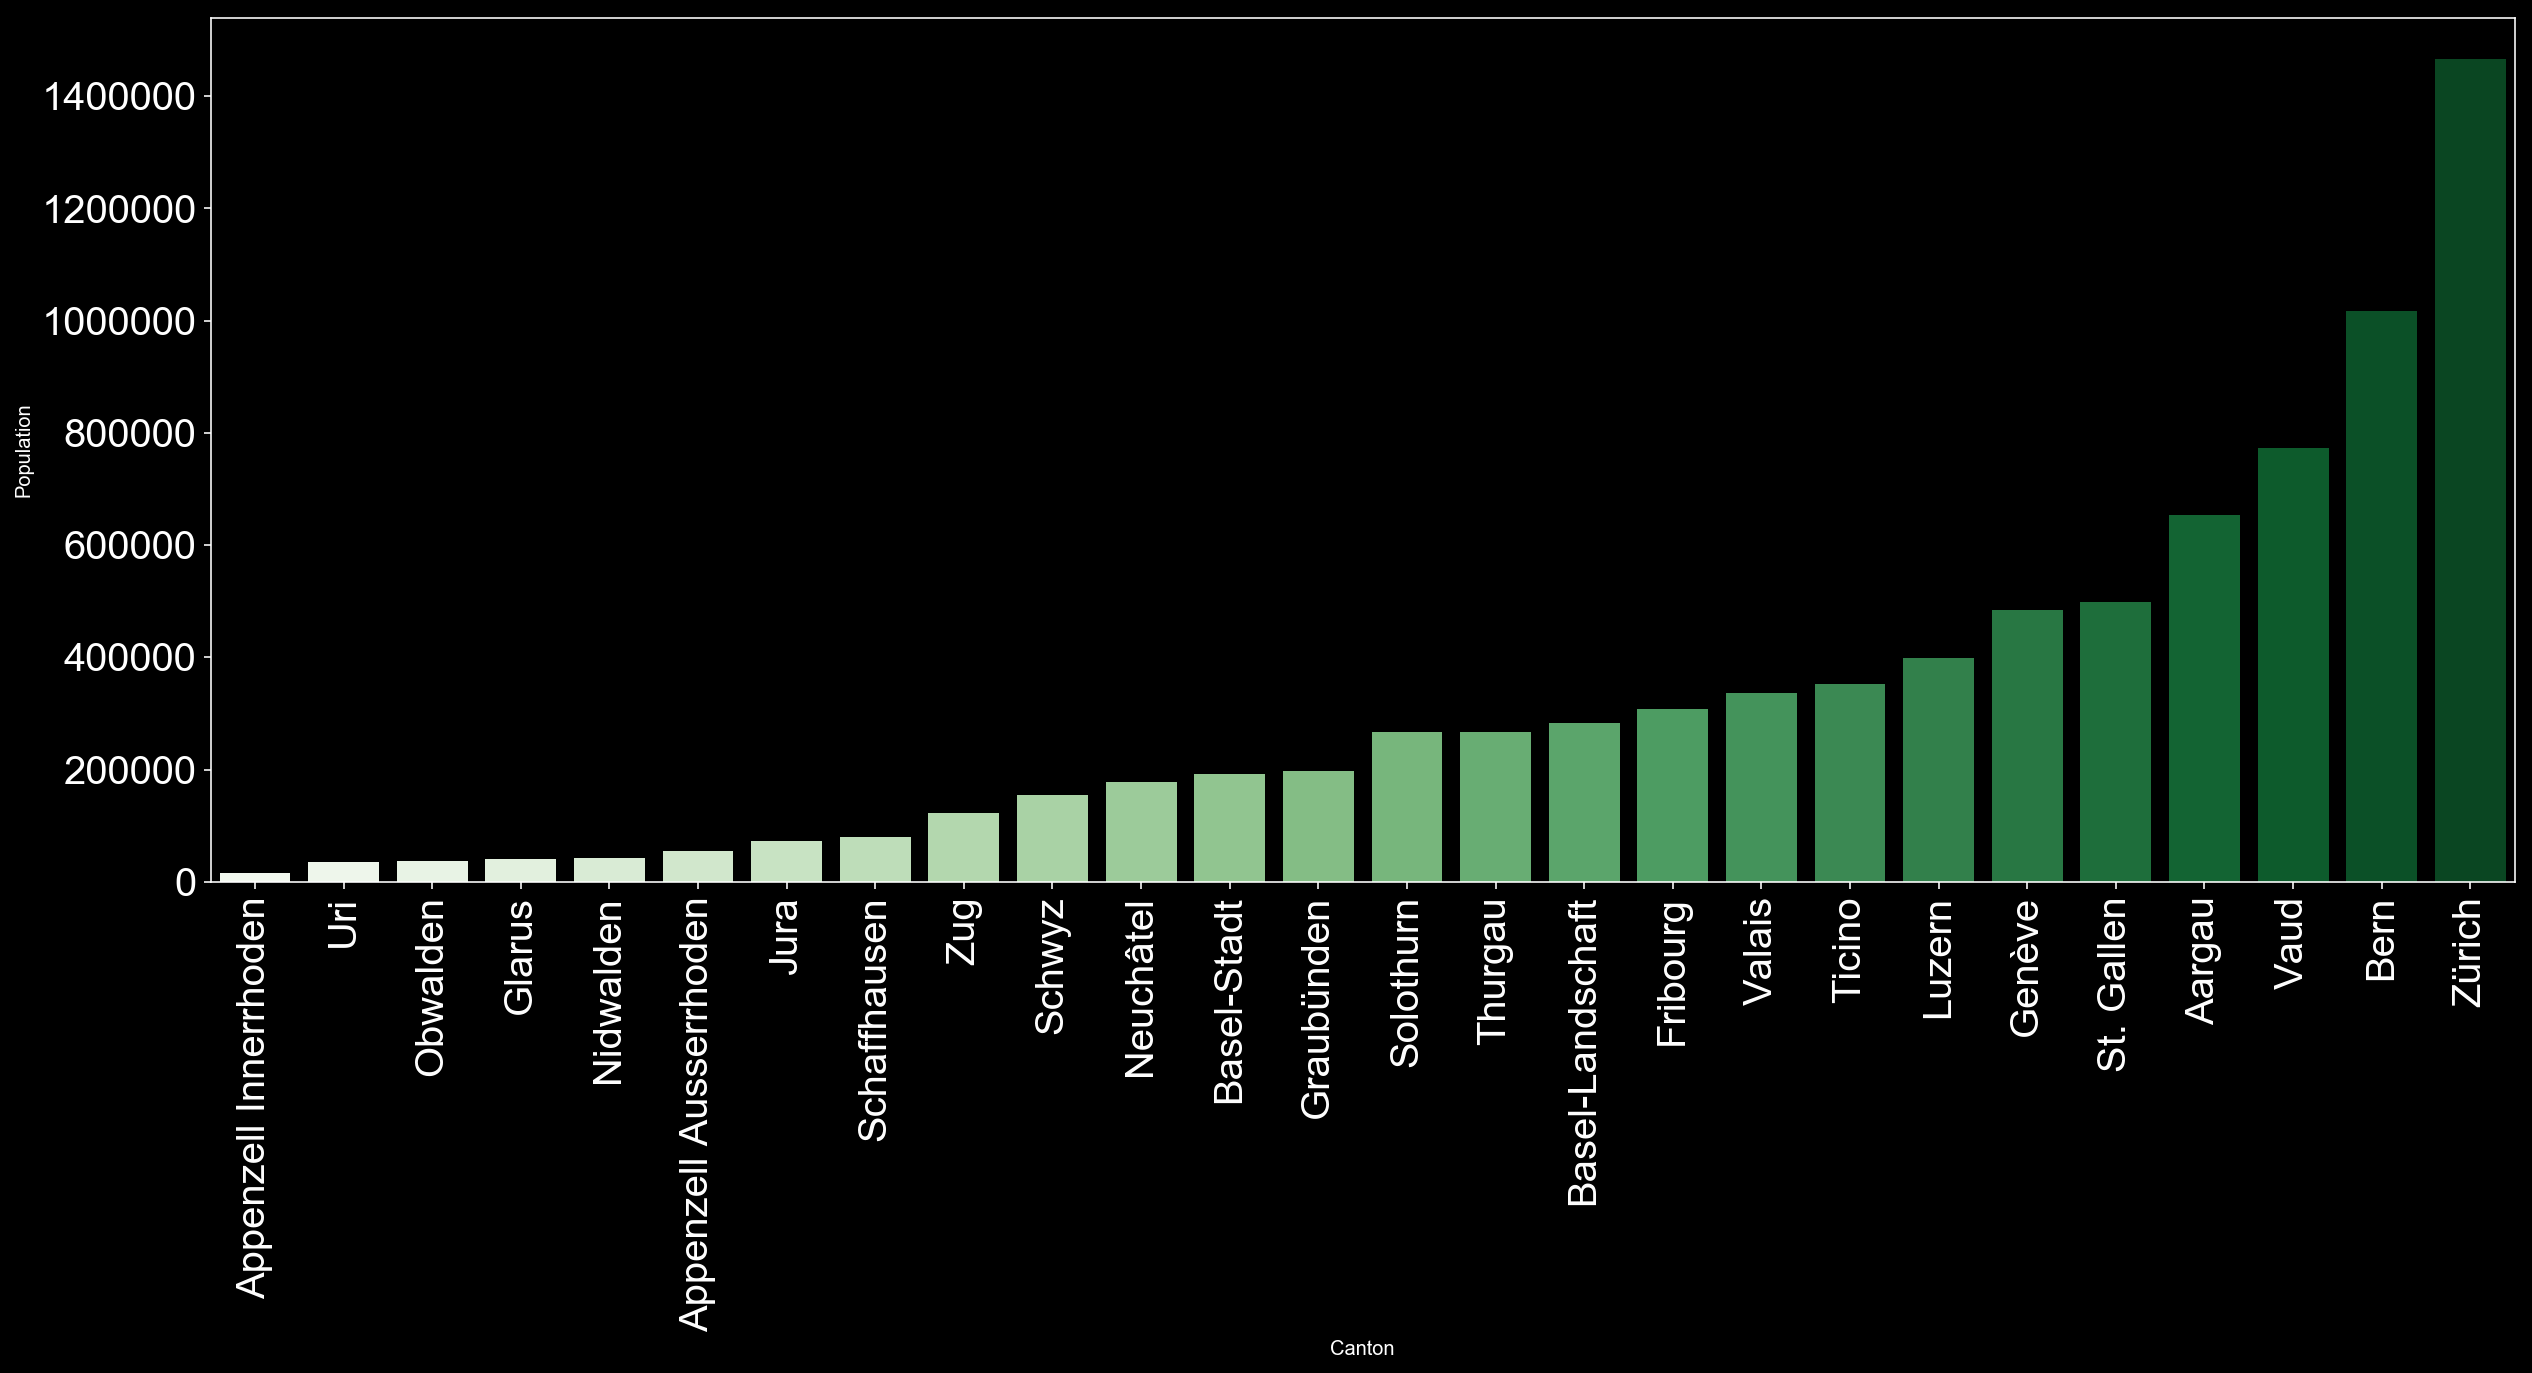

In [44]:
plotPopulation(dataSwiss, 'Canton', 'cantonPopulation', 20, 20)

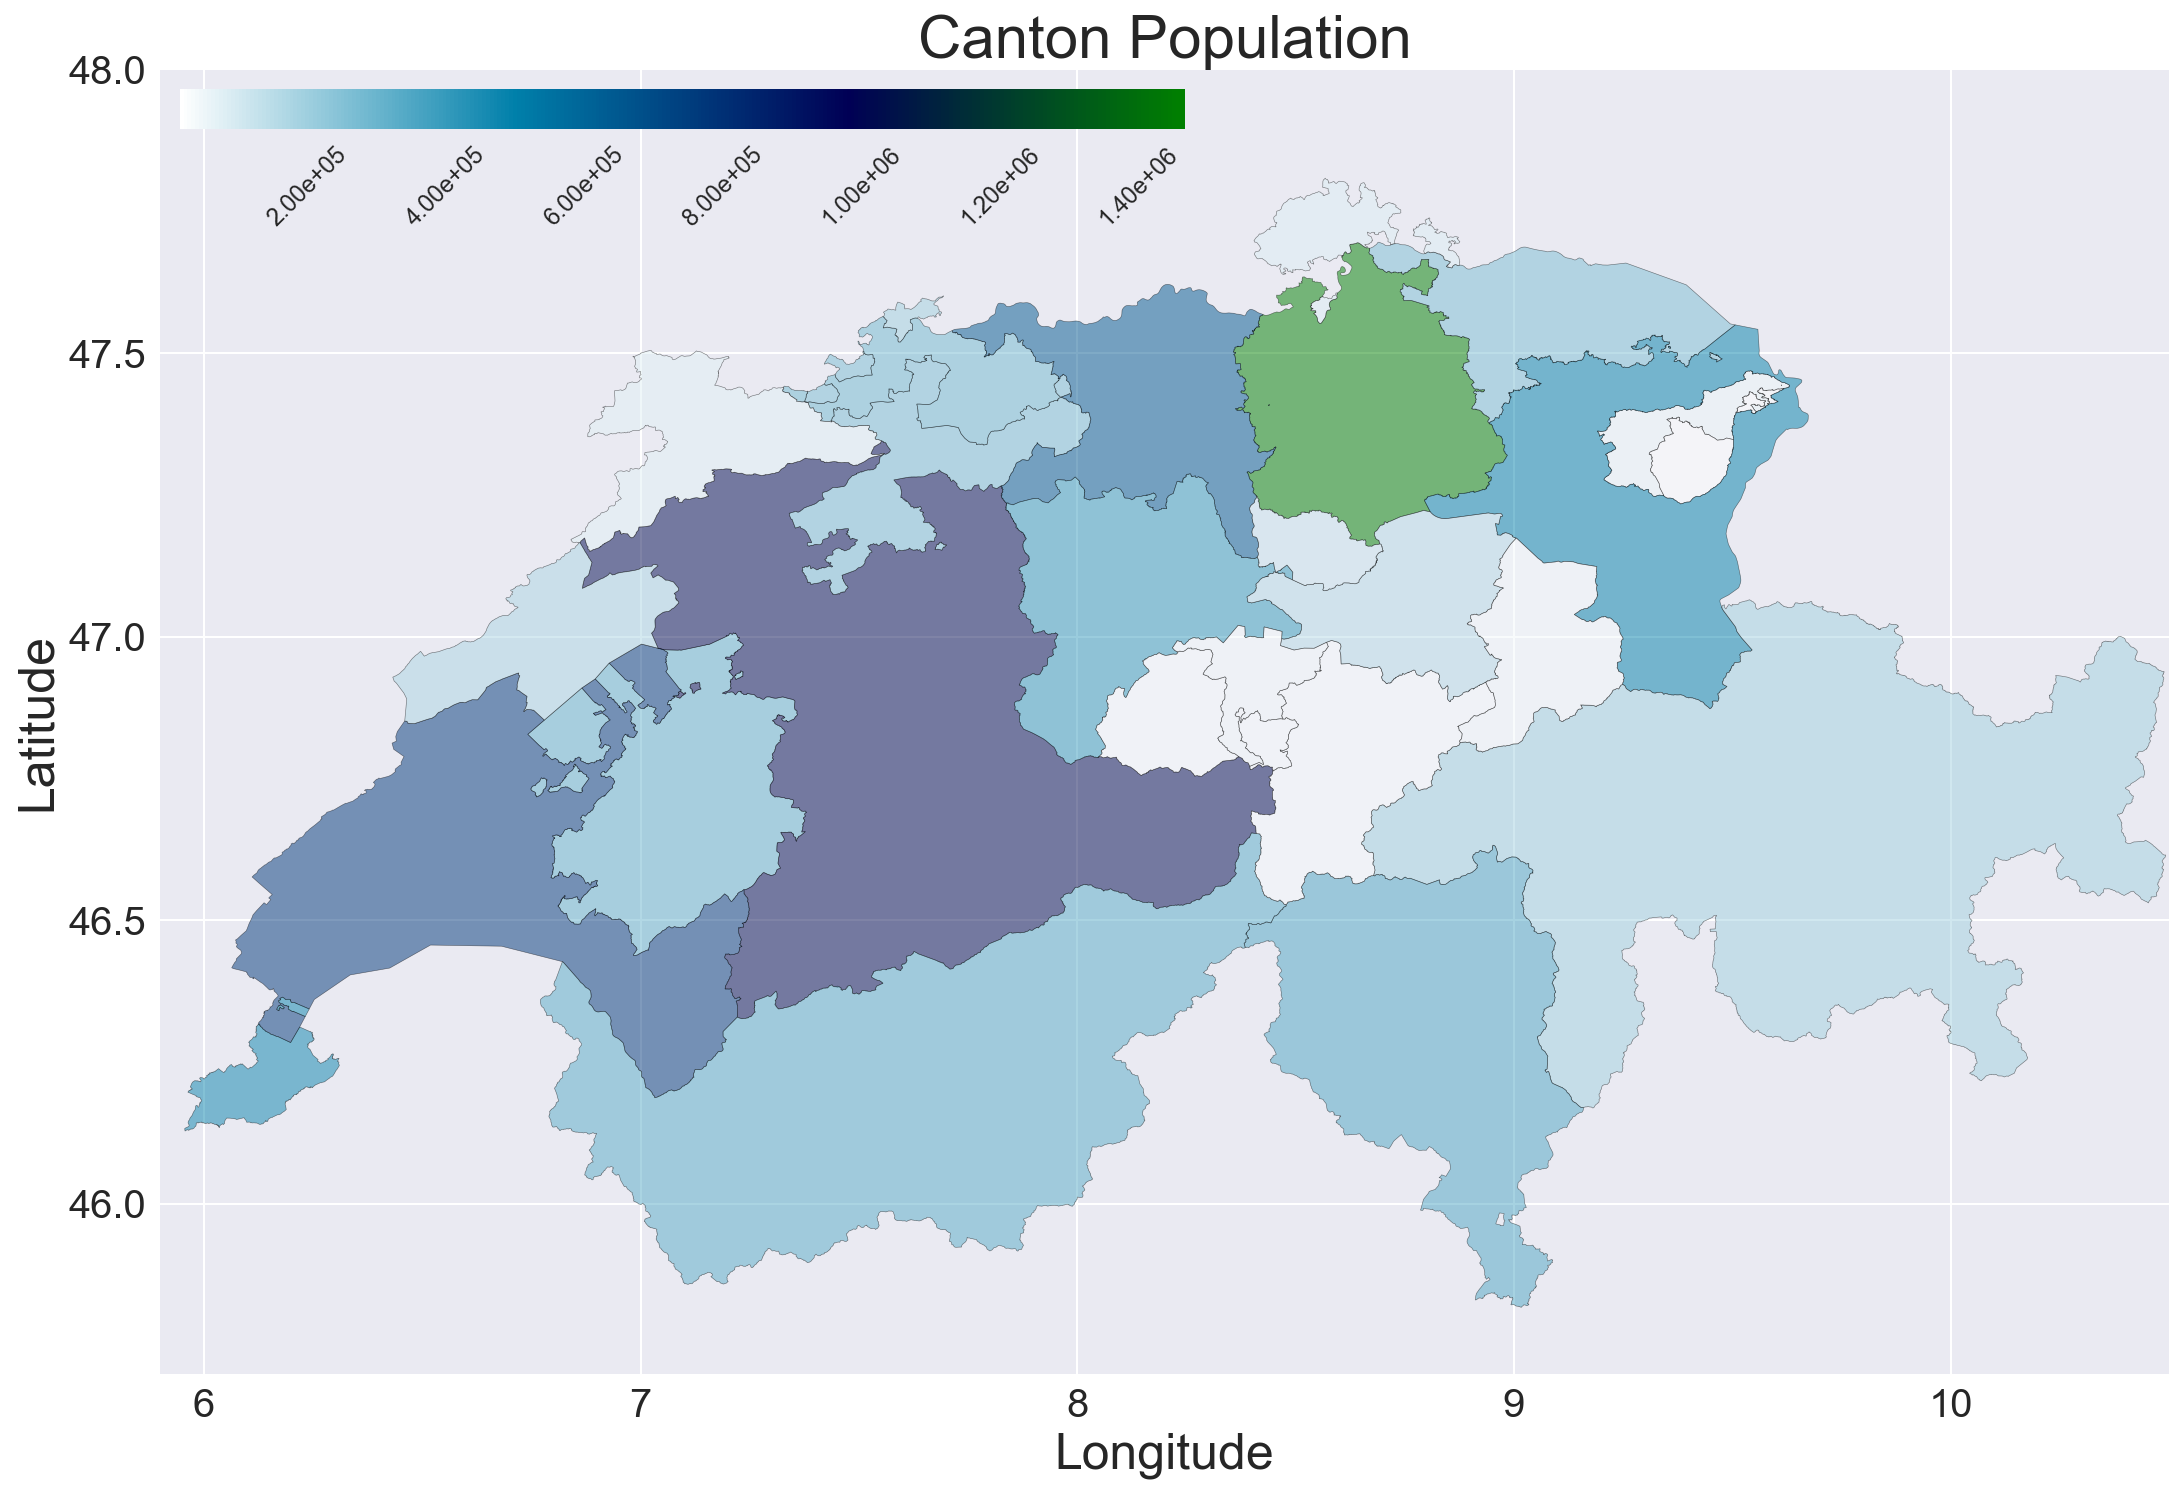

In [45]:
plotGeo(cmap, value, string, dfCan.canCoord)

In [ ]:
g.serialize(destination='ontologyRetreatPart3.rdf', format='nt')